<a href="https://colab.research.google.com/github/MBrandao07/Case_Porto_Seguro_Kaggle/blob/main/Case_Porto_Seguro_Modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score
import pod_academy_functions as pod # a biblioteca pod_academy_functions é uma biblioteca com várias funções criada durante o curso da PoD Academy

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# verificando todas as funções na biblioteca pod_academy_functions
with open('/content/drive/MyDrive/1 - Aulas PoD Academy/Cientista de Dados POD/Aulas/Case Porto Seguro/pod_academy_functions.py', 'r') as f:
    print(f.read())

# Função para cálculo do Gini normalizado

def gini_normalizado(actual, pred, cmpcol = 0, sortcol = 1):
    import numpy as np
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def pod_academy_generate_metadata(dataframe):
    import pandas as pd
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(datafram

In [ ]:
abt_00 = pd.read_csv('/content/drive/MyDrive/1 - Aulas PoD Academy/Cientista de Dados POD/Aulas/Case Porto Seguro/abt_fs_train.csv',index_col=0)

abt_00.head()

,ps_ind_03,ps_ind_15,ps_reg_02,ps_reg_03,ps_car_11_cat,ps_car_13,ps_car_14,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_10,ps_calc_11,ps_calc_14,target
0,1.695565,0.761809,2.869279,2.551830e+00,1.265515,3.282777,0.933695,0.870596,1.570820,-0.869620,-0.493106,-0.189128,0.896386,0
1,-0.527733,0.479805,0.149555,-2.906527e-01,0.689777,-0.510640,0.517388,1.567305,0.873885,1.220110,-1.182005,-1.045842,1.624615,0
2,0.583916,-2.058230,2.374783,1.072055e+00,1.265515,-1.087392,0.416784,1.218950,-0.868451,1.220110,1.918039,-0.617485,0.896386,0
3,-0.157184,-0.366207,-0.839435,-3.550803e-16,-0.673815,-0.190735,0.152728,-1.219531,-1.565385,1.220110,0.195793,-0.189128,0.168156,0
4,-0.898283,-0.366207,0.149555,-4.247585e-01,-1.522272,0.075932,-1.134278,1.218950,-0.171516,1.568398,-1.526454,1.095943,-0.924188,1


#### Vamos verificar o balanceamento da nossa variável target na base de treino

In [ ]:
# verificando o balanceamento da variável target
abt_00.target.describe()

,target
count,416648.000000
mean,0.036263
std,0.186945
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Podemos ver que a quantidade de vezes em que o evento acontece é muito pequena, então quando retirarmos uma amostra devemos prestar atenção nessa distribuição

#### Retirando amostras

In [ ]:
# retirando uma amostra aleatória
abt_00_sample = abt_00.sample(n=30000)
abt_00_sample['target'].describe()

,target
count,30000.000000
mean,0.033867
std,0.180889
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
# retirando uma amostra balanceada
evento = abt_00[abt_00['target'] == 1]
nevento = abt_00[abt_00['target'] == 0]

# amostragem aleatória dos negativos
negativos_amostra = nevento.sample(n=len(evento))

# concatenando as duas partes para obter a amostra balanceada
amostra_balanceada = pd.concat([evento, negativos_amostra])

# embaralhando os dados
amostra_balanceada = amostra_balanceada.sample(frac=1).reset_index(drop=True)

amostra_balanceada.shape

(30218, 14)

In [ ]:
amostra_balanceada.target.describe()

,target
count,30218.000000
mean,0.500000
std,0.500008
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


#### Agora que temos uma amostra balanceada, vamos dividir os dados em treino e teste

In [ ]:
# separando as variáveis explicativas do target
X = amostra_balanceada.drop(columns=["target"])
y = amostra_balanceada["target"]

In [ ]:
# separando a amostra utilizando o Holdout 70/30 (out-of-sample)

from sklearn.model_selection import train_test_split

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

((21152, 13), (9066, 13))

## Testando diferentes modelos

### **Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import time

# definindo o modelo
model = DecisionTreeClassifier(random_state=42)

# definindo os parâmetros para o grid search
param_grid = {
    'criterion':['gini','entropy'],
    'splitter':['best', 'random'],
    'max_depth': [2, 4, 6, 10, 20, 30], # Profundidade máxima da árvore
    'min_samples_split': [0.002, 0.004, 0.008, 0.01], # Número mínimo de amostras necessárias para dividir um nó interno.
    'min_samples_leaf': [0.008,0.02,0.04,0.07,0.1], # Número mínimo de amostras necessárias para estar em um nó folha.
}

# calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['splitter']) * len(param_grid['criterion']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# medindo o tempo de execução
start_time = time.time()

# treinando o modelo com o grid search
grid.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

mins, secs = divmod(elapsed_time, 60)

# exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)
predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

print(f"Tempo de execução: {int(mins)} minutos e {int(secs)} segundos")

best_model_dt = grid.best_estimator_

Total de Modelos a serem Treinados: 2400
Melhores Parâmetros:  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 0.02, 'min_samples_split': 0.002, 'splitter': 'best'}
Melhor AUC:  0.589950214551439
Gini normalizado -->  0.17
Tempo de execução: 1 minutos e 28 segundos


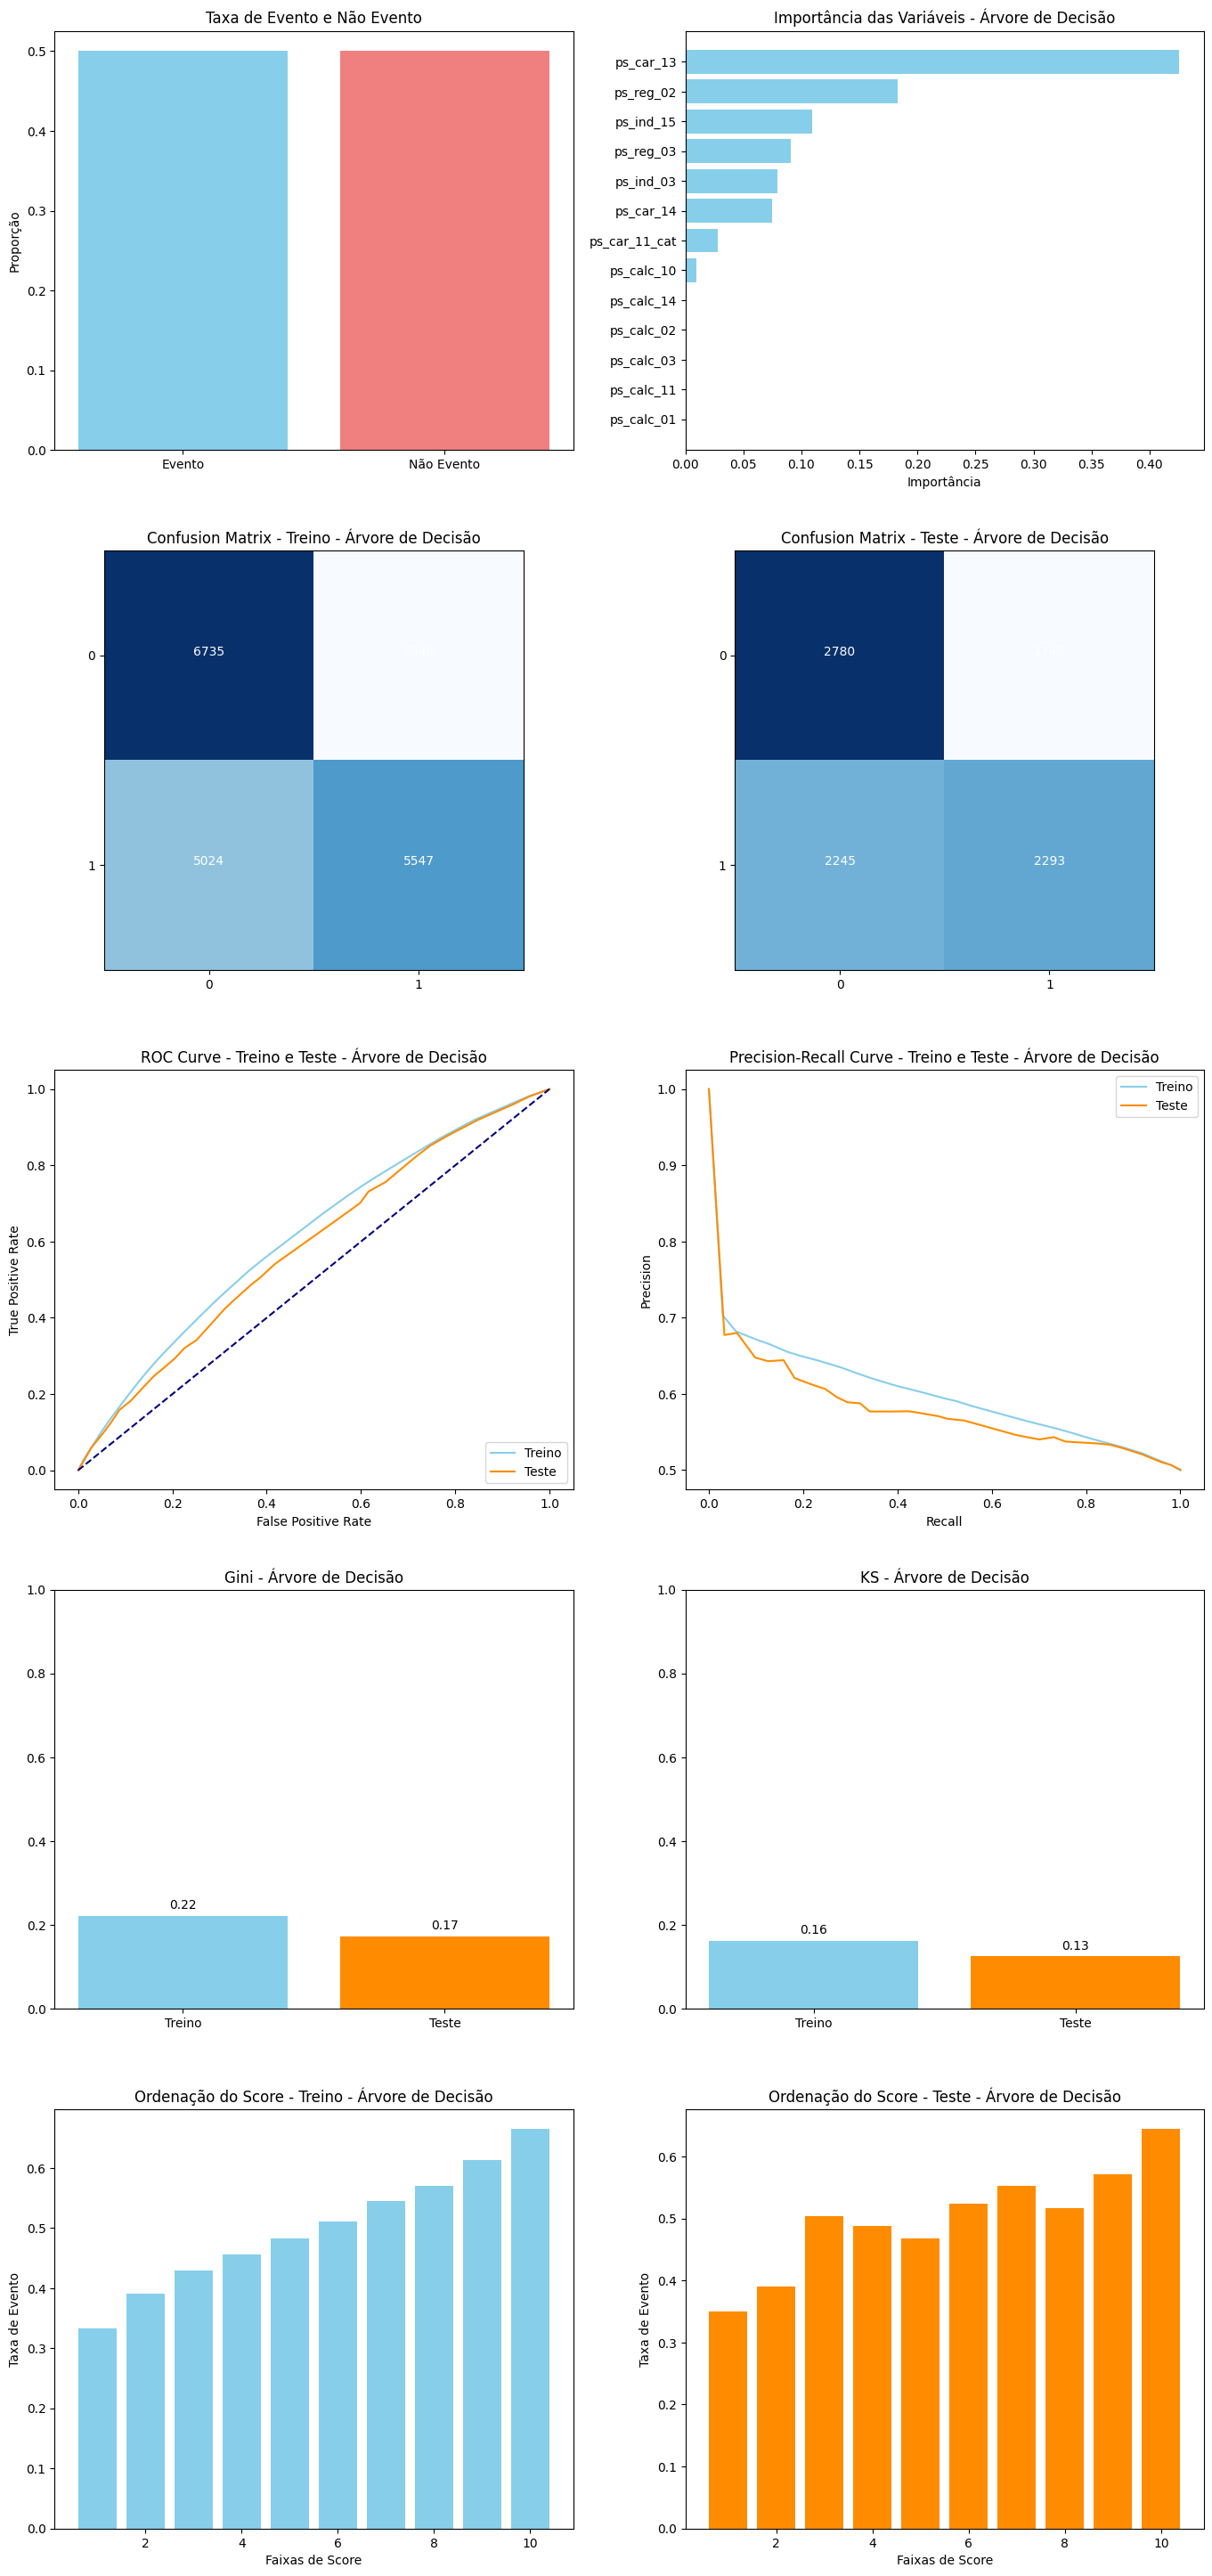

In [ ]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, best_model_dt,nm_modelo='Árvore de Decisão')

### **Regressão Logística**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# definindo o modelo
model = LogisticRegression(max_iter=100)
model_sgs = LogisticRegression(max_iter=100)

# penalty='l2', # Tipo de regularização: 'l1', 'l2', 'elasticnet', 'none'
# dual=False, # Formulação primal e dual do problema de otimização da regressão logística, sendo recomendado manter como False quando temos mais amostras do que Variáveis
# tol=0.0001, # Tolerância para critério de parada.
# C=1.0, # Inverso da força de regularização; deve ser um valor flutuante positivo. Como valores menores, especifica uma regularização mais forte.
# fit_intercept=True, # Especifica se uma constante (ou seja, viés ou interceptação) deve ser adicionada à função de decisão.
# intercept_scaling=1, # Útil apenas quando o solver 'liblinear' é usado e self.fit_intercept é definido como True.
# class_weight=None, # Pesos associados às classes. Se não for fornecido, todas as classes são supostas ter peso um.
# random_state=None, # Semente usada pelo gerador de números aleatórios.
# solver='lbfgs', # Algoritmo a ser usado no problema de otimização: {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, padrão='lbfgs'
# max_iter=100, # Número máximo de iterações para os solvers convergirem.
# multi_class='auto', # Se a opção escolhida for 'ovr', então um problema binário é ajustado para cada rótulo. Para 'multinomial', a perda minimizada é a perda multinomial ajustando todo o conjunto de dados de uma vez.
# verbose=0, # Para o solver 'liblinear' e 'lbfgs', defina o valor para qualquer inteiro positivo para classificar a verbosidade.
# warm_start=False, # Quando definido como True, reutiliza a solução da chamada anterior para ajustar como inicialização, caso contrário, apenas apaga a solução anterior.
# l1_ratio=None # O valor de Elastic-Net mixing parameter, com 0 <= l1_ratio <= 1. Somente usado se penalty='elasticnet'.


# definindo os parâmetros para o grid search
param_grid = {
    'penalty':['l1','l2'],
    'tol':[0.00001,0.0001,0.001, 0.0001],
    'C': [1.0, 2.0],
    'solver':['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}]
}



# calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['penalty']) * len(param_grid['tol']) * len(param_grid['C']) * len(param_grid['solver']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# medindo o tempo de execução
start_time = time.time()

# treinando o modelo com o grid search
grid.fit(X_train, y_train)

# treinando modelo sem grid search para comparar
model_sgs.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

mins, secs = divmod(elapsed_time, 60)

# exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

print(f"Tempo de execução: {int(mins)} minutos e {int(secs)} segundos")

best_model_rl = grid.best_estimator_

Total de Modelos a serem Treinados: 160
Melhores Parâmetros:  {'C': 1.0, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}
Melhor AUC:  0.5926046443544244
Gini normalizado -->  0.21
Tempo de execução: 1 minutos e 14 segundos


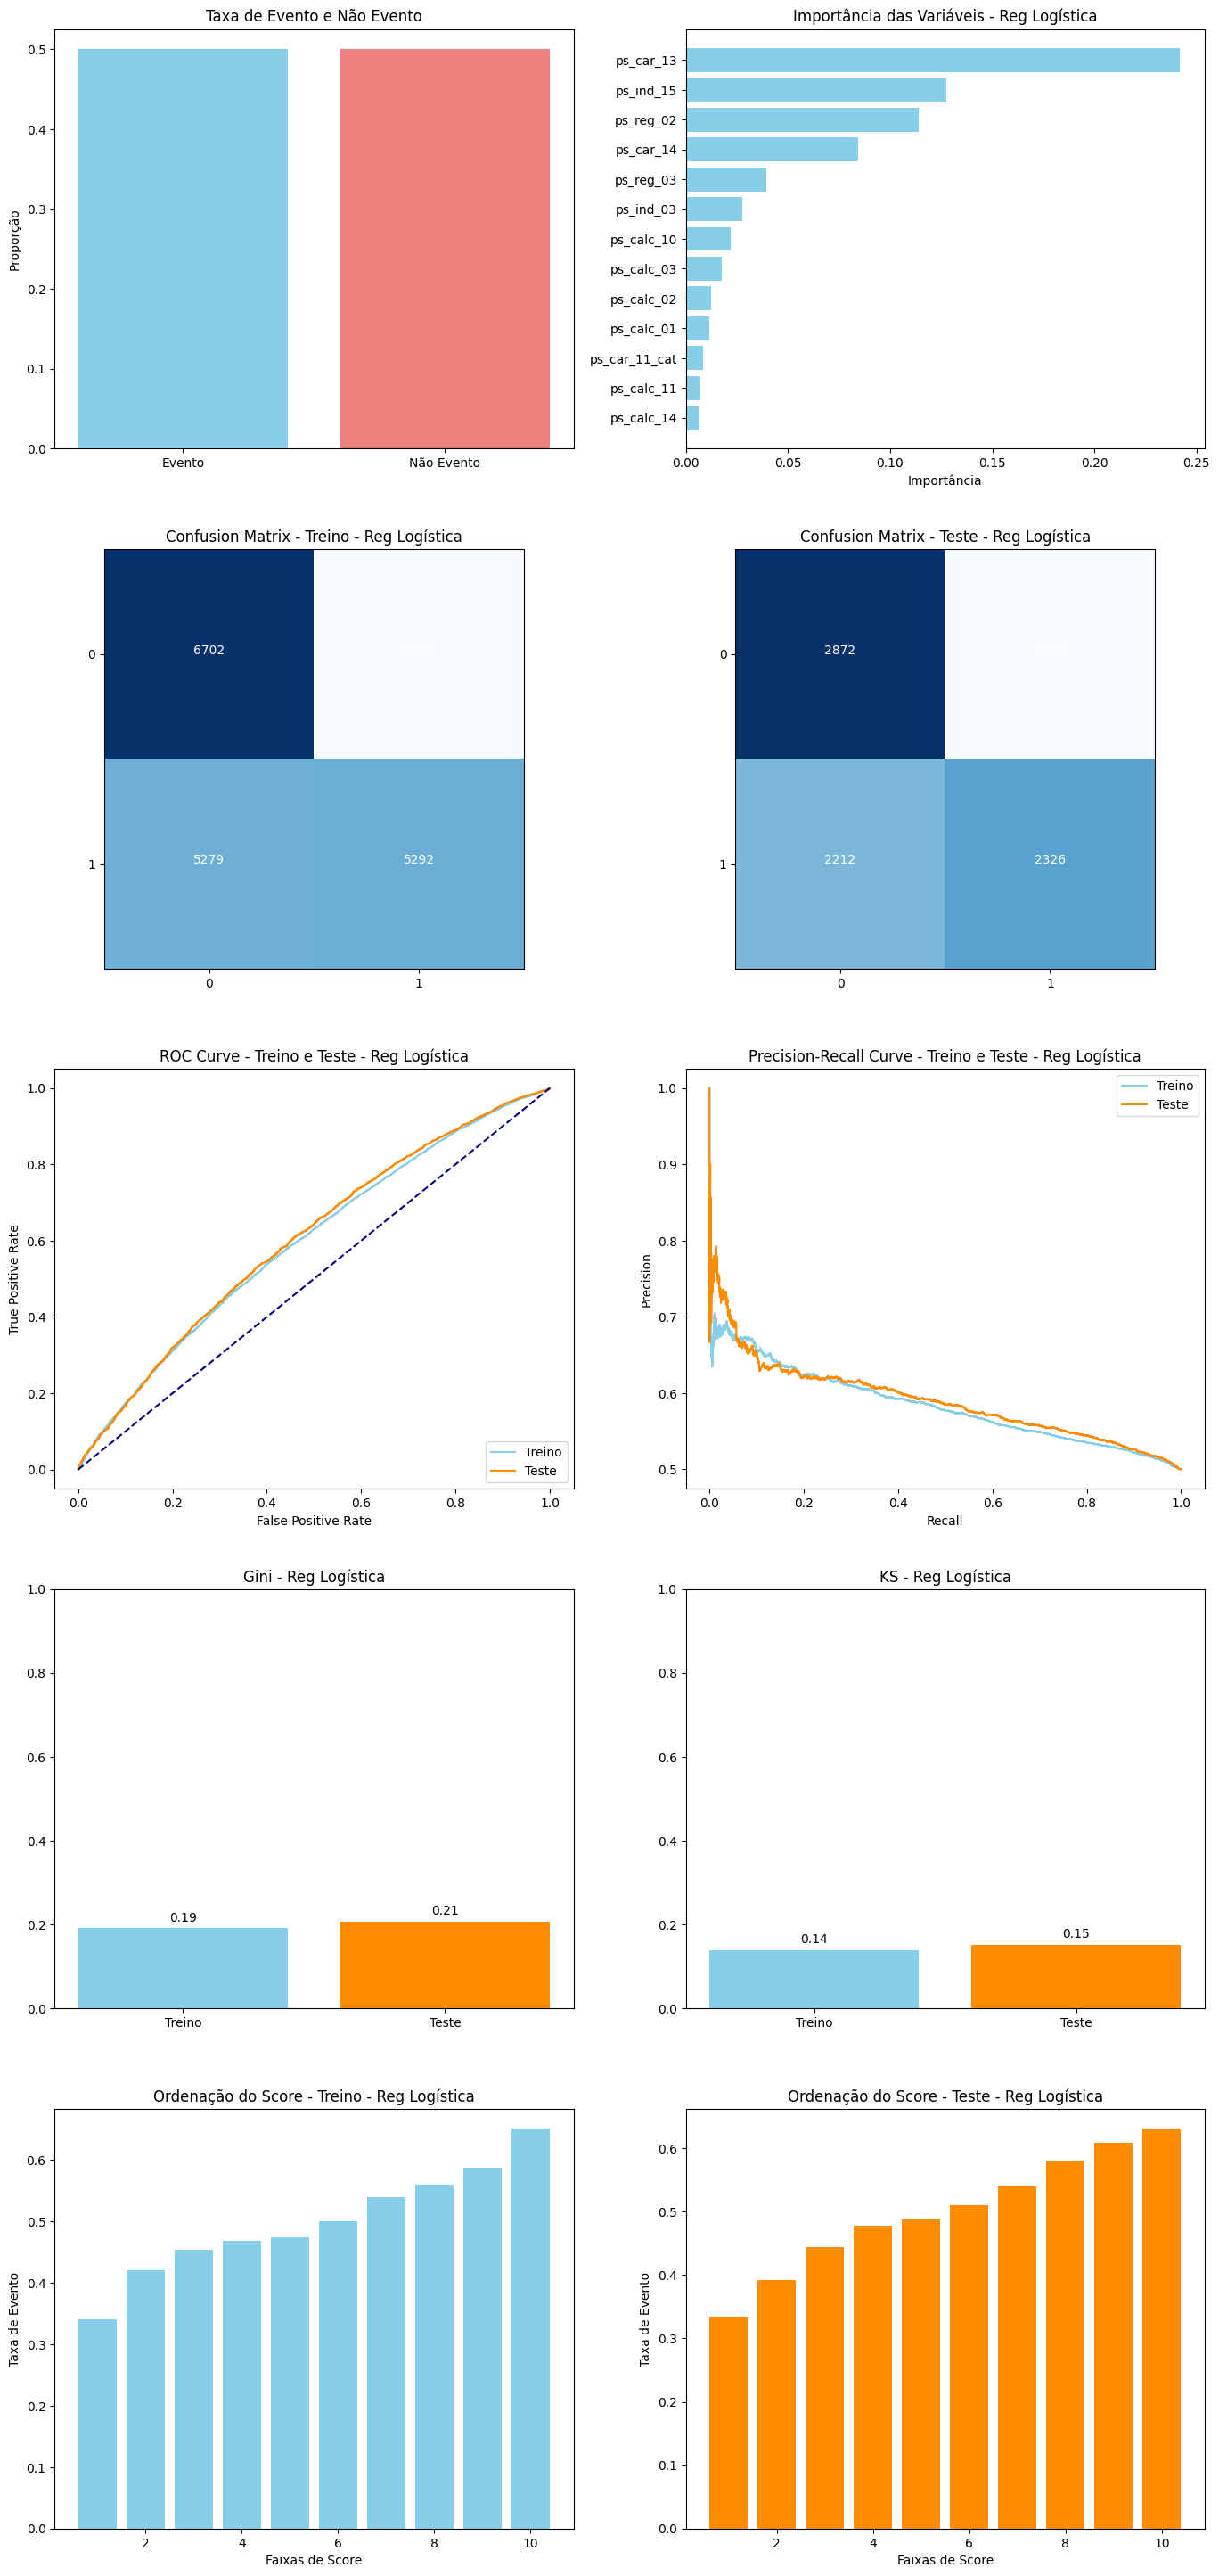

In [ ]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, model_sgs,nm_modelo='Reg Logística')

### **Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# definindo o modelo
model = RandomForestClassifier()

# n_estimators=100,  # Número de árvores na floresta.
# criterion='gini',  # Função para medir a qualidade de uma divisão ("gini" ou "entropy").
# max_depth=None,  # Profundidade máxima das árvores. None significa que os nós são expandidos até ficarem puros.
# min_samples_split=2,  # Número mínimo de amostras necessárias para dividir um nó interno.
# min_samples_leaf=1,  # Número mínimo de amostras necessárias para estar em um nó folha.
# min_weight_fraction_leaf=0.0,  # Fração mínima ponderada da soma total de pesos necessária para estar em um nó folha.
# max_features='auto',  # Número de características a considerar ao procurar a melhor divisão.
# max_leaf_nodes=None,  # Número máximo de nós folha.
# min_impurity_decrease=0.0,  # Um nó será dividido se a divisão induzir a uma diminuição da impureza maior ou igual a este valor.
# bootstrap=True,  # Se as amostras de bootstrap são usadas ao construir árvores.
# oob_score=False,  # Se usar amostras out-of-bag para estimar a precisão generalizada.
# n_jobs=None,  # Número de jobs a serem executados em paralelo para ajuste e previsão. -1 significa usar todos os processadores.
# random_state=None,  # Controla a aleatoriedade do bootstrap e da seleção de features.
# verbose=0,  # Controla a verbosidade do processo de treinamento.
# warm_start=False,  # Reutiliza a solução da chamada anterior para ajustar e adicionar mais estimadores ao ensemble.
# class_weight=None  # Pesos associados às classes. Pode ser "balanced", "balanced_subsample" ou um dicionário com os pesos.


# definindo os parâmetros para o grid search
param_grid = {
    'n_estimators': [10, 50, 100],
    #'criterion':['gini','entropy'],
    'max_depth': [2, 3, 5],
    'min_samples_split': [0.001, 0.01],
    'min_samples_leaf': [2, 0.01],
    'bootstrap': [True, False],
    # 'max_features': ['auto', 'sqrt', 'log2']
}

# definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# medindo o tempo de execução
start_time = time.time()

# treinando o modelo com o grid search
grid.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

mins, secs = divmod(elapsed_time, 60)

# exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

print(f"Tempo de execução: {int(mins)} minutos e {int(secs)} segundos")

best_model_rf = grid.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Melhores Parâmetros:  {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 0.001, 'n_estimators': 50}
Melhor AUC:  0.6050188860433585
Gini normalizado -->  0.21
Tempo de execução: 3 minutos e 46 segundos


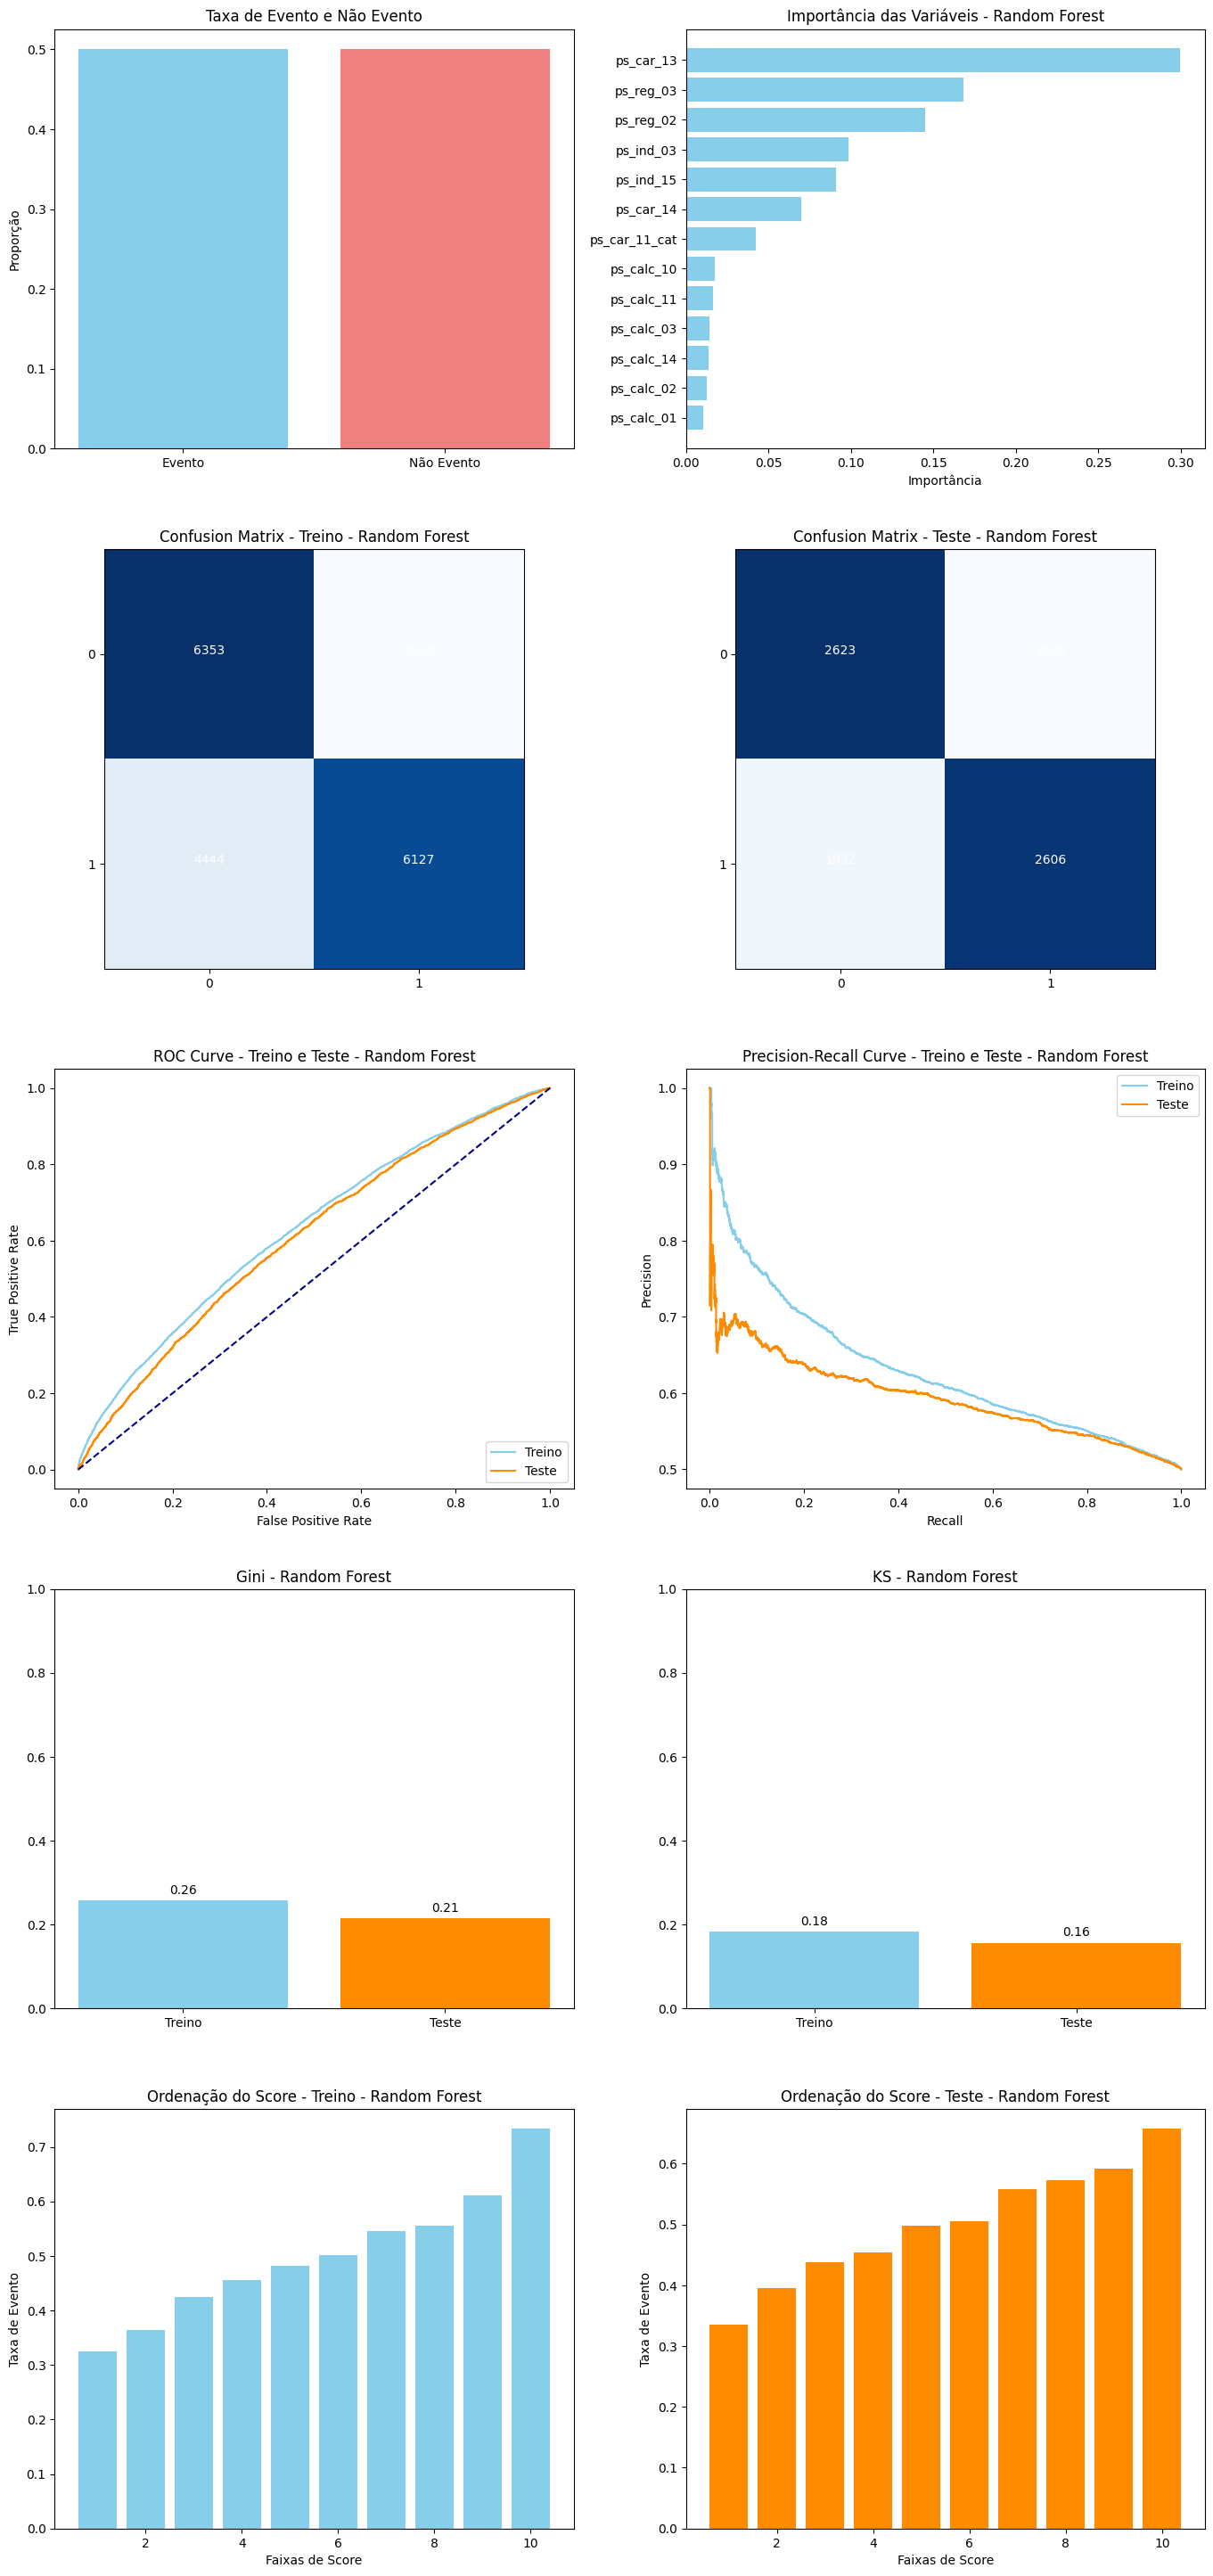

In [ ]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, best_model_rf,nm_modelo='Random Forest')

### **LightGBM**

In [ ]:
import lightgbm as lgb

# Definindo o modelo
model = lgb.LGBMClassifier()


# Definindo os parâmetros para o grid search
param_grid = {
    'max_depth' : [1, 3, 5],
    'num_leaves': [3, 5],
    'reg_alpha': [0.1],
    'min_data_in_leaf': [50, 300, 500],
    'lambda_l1': [1, 1.5],
    'lambda_l2': [1, 1.5]
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# medindo o tempo de execução
start_time = time.time()

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

mins, secs = divmod(elapsed_time, 60)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

print(f"Tempo de execução: {int(mins)} minutos e {int(secs)} segundos")

best_model_lightgbm = grid.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
Melhores Parâmetros:  {'lambda_l1': 1, 'lambda_l2': 1.5, 'max_depth': 3, 'min_data_in_leaf': 300, 'num_leaves': 3, 'reg_alpha': 0.1}
Melhor AUC:  0.6106950601659488
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning

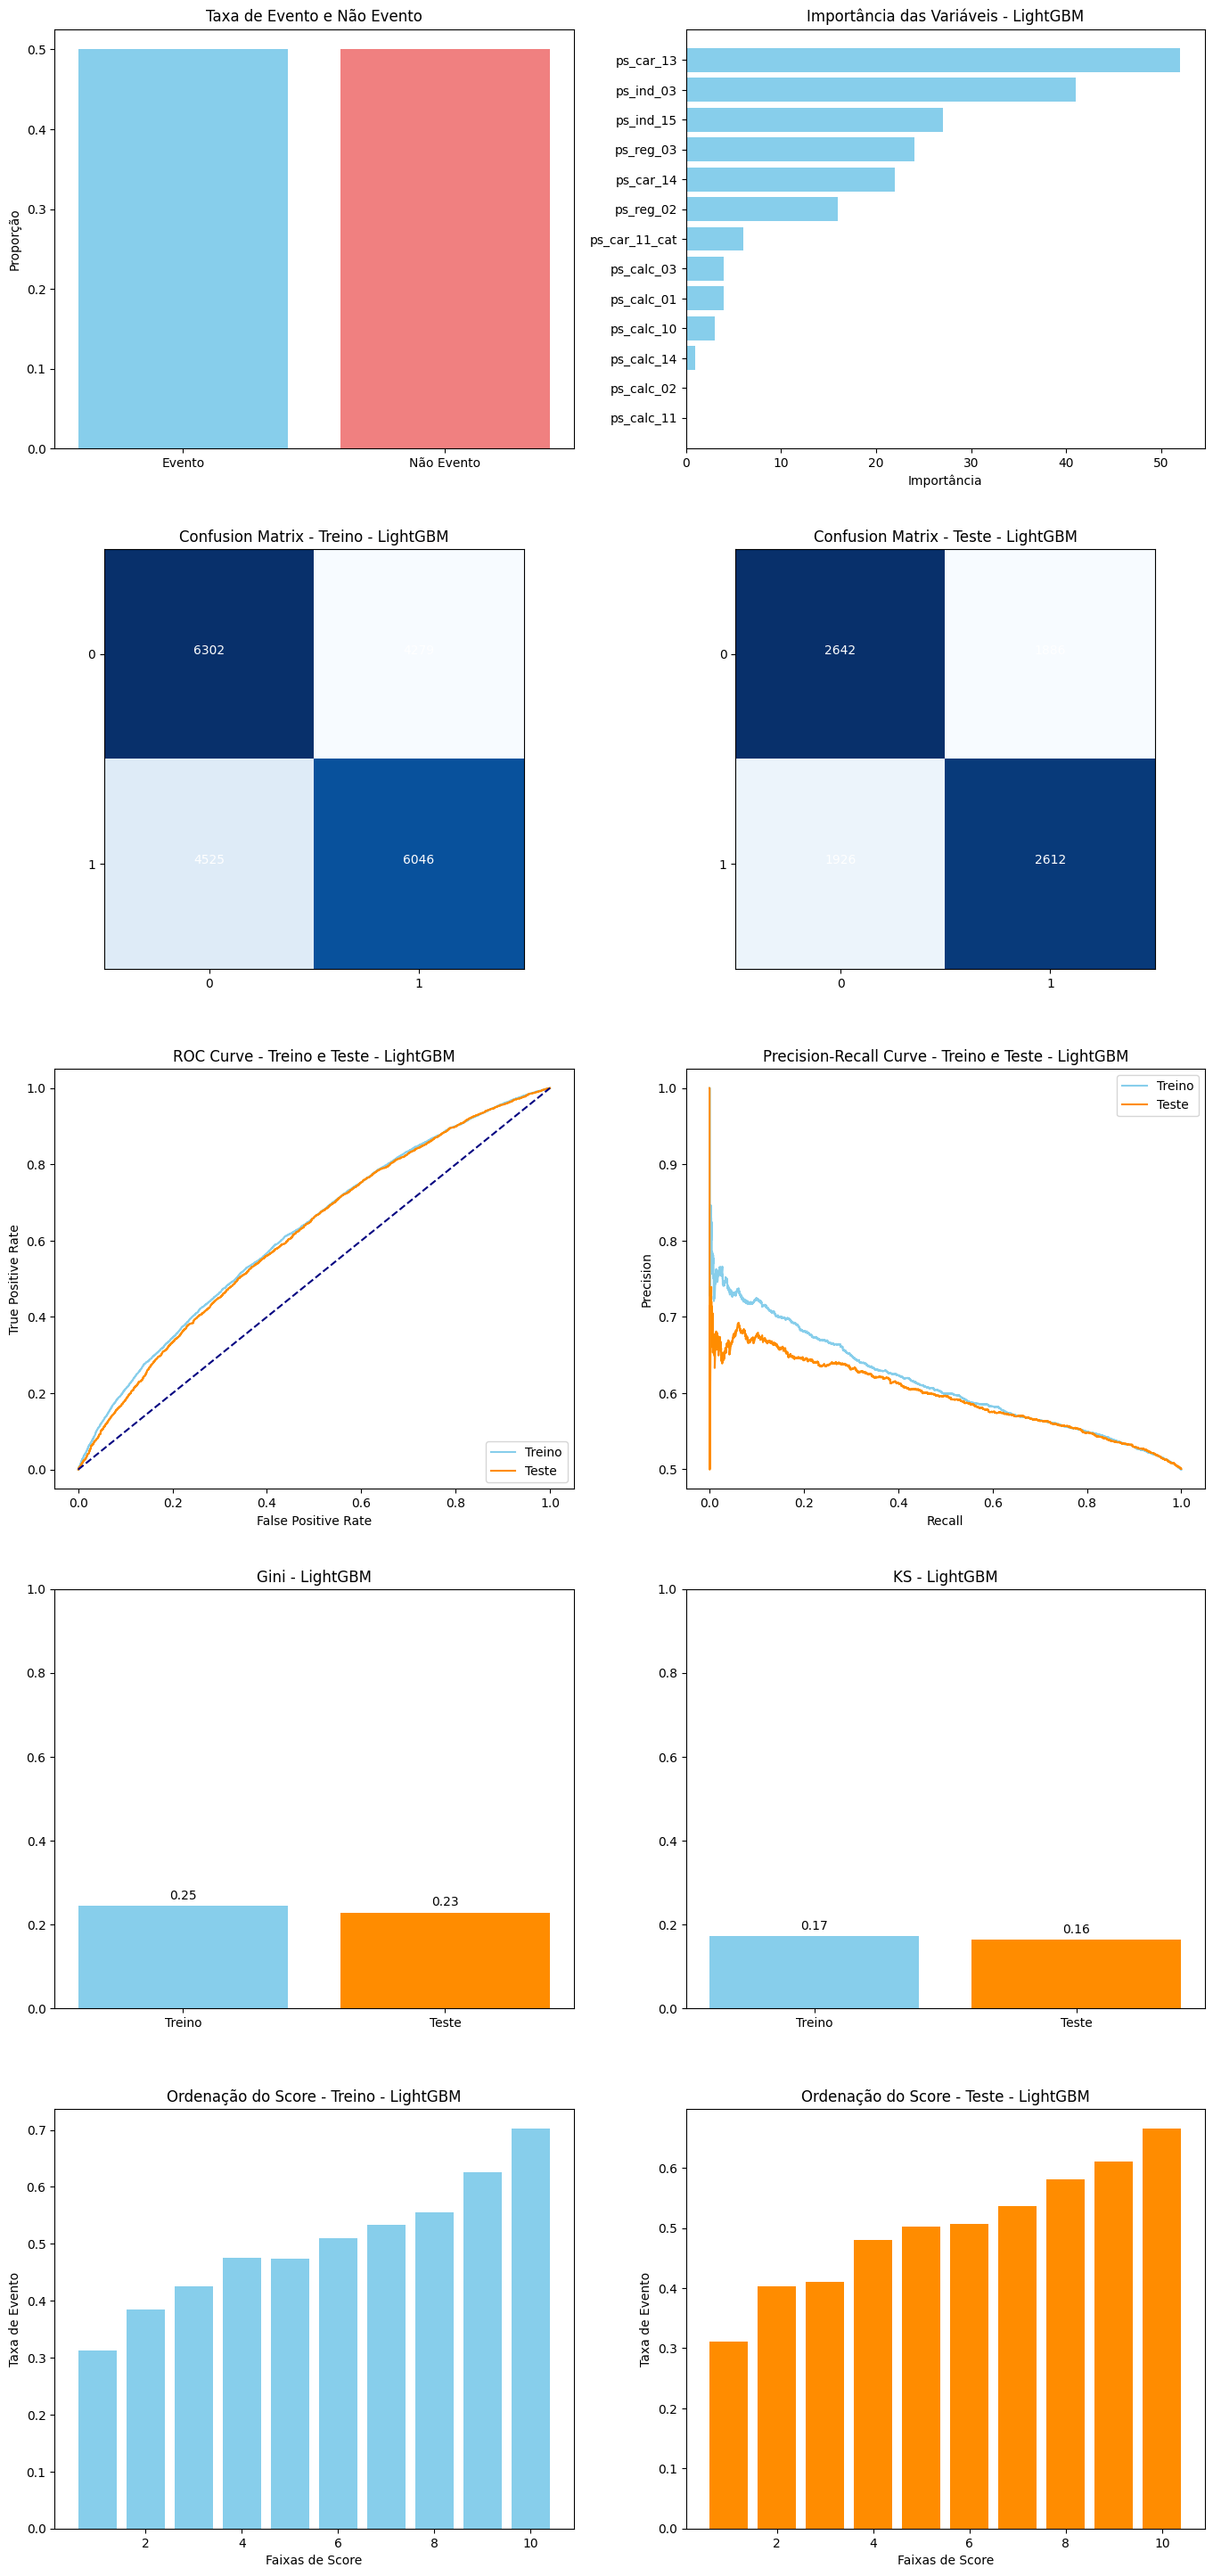

In [ ]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, best_model_lightgbm,nm_modelo='LightGBM')

#### Salvando os artefatos dos modelos

In [ ]:
import pickle

with open('/content/drive/MyDrive/1 - Aulas PoD Academy/Cientista de Dados POD/Aulas/Case Porto Seguro/best_model_dt.pkl', 'wb') as file:
  pickle.dump(best_model_dt, file)

with open('/content/drive/MyDrive/1 - Aulas PoD Academy/Cientista de Dados POD/Aulas/Case Porto Seguro/best_model_rl.pkl', 'wb') as file:
  pickle.dump(best_model_rl, file)

with open('/content/drive/MyDrive/1 - Aulas PoD Academy/Cientista de Dados POD/Aulas/Case Porto Seguro/best_model_rf.pkl', 'wb') as file:
  pickle.dump(best_model_rf, file)

with open('/content/drive/MyDrive/1 - Aulas PoD Academy/Cientista de Dados POD/Aulas/Case Porto Seguro/best_model_lightgbm.pkl', 'wb') as file:
  pickle.dump(best_model_lightgbm, file)